<a href="https://colab.research.google.com/github/sinarazi/Instance_segmentation_froth_flotation/blob/main/Instance_segmentation_froth_flotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instance segmentation of froth flotation using Mask R-CNN

### This section ensures all the library version dependeices are met

In [ ]:
! pip install 'h5py==2.10.0' --force-reinstall


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip install -U scikit-image==0.16.2

### Run the following cell TWICE to ensure keras 2.1.0 is installed.

In [ ]:
!pip install -U keras==2.1.0

In [5]:
import tensorflow
import skimage
print(tensorflow.__version__,  skimage.__version__)

1.15.2 0.16.2


In [7]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.0'

In [ ]:
! git clone https://github.com/matterport/Mask_RCNN

In [10]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

### Next, we read input and unzip it. This can take time.

In [ ]:
# Downloading dataset from github. This cell needs execution ONLY ONCE!
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_test.zip -c
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_train.zip -c

!mkdir stage1_train stage1_test

!unzip stage1_train.zip -d stage1_train/
!unzip stage1_test.zip -d stage1_test/

In [12]:
# # Data Path
TRAIN_PATH = './stage1_train/'
#TEST_PATH = './test/' # froth dataset
TEST_PATH = './stage1_test' # nucleus
# # Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]


In [13]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


# Resnet backbone

In [15]:
import keras.backend as K
import keras.layers as KL
import keras.engine as KE
import keras.models as KM

def identity_block(input_tensor, kernel_size, filters, stage, block,
                   use_bias=True, train_bn=True):
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (1, 1), name=conv_name_base + '2a',
                  use_bias=use_bias)(input_tensor)
    x = BatchNorm(name=bn_name_base + '2a')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2b')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c',
                  use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2c')(x, training=train_bn)

    x = KL.Add()([x, input_tensor])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block,
               strides=(2, 2), use_bias=True, train_bn=True):
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (1, 1), strides=strides,
                  name=conv_name_base + '2a', use_bias=use_bias)(input_tensor)
    x = BatchNorm(name=bn_name_base + '2a')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2b')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base +
                  '2c', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2c')(x, training=train_bn)

    shortcut = KL.Conv2D(nb_filter3, (1, 1), strides=strides,
                         name=conv_name_base + '1', use_bias=use_bias)(input_tensor)
    shortcut = BatchNorm(name=bn_name_base + '1')(shortcut, training=train_bn)

    x = KL.Add()([x, shortcut])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x


def resnet_graph(input_image, architecture, stage5=False, train_bn=True):
    assert architecture in ["resnet50", "resnet101"]
    # Stage 1
    x = KL.ZeroPadding2D((3, 3))(input_image)
    x = KL.Conv2D(64, (7, 7), strides=(2, 2), name='conv1', use_bias=True)(x)
    x = BatchNorm(name='bn_conv1')(x, training=train_bn)
    x = KL.Activation('relu')(x)
    C1 = x = KL.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
    # Stage 2
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), train_bn=train_bn)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', train_bn=train_bn)
    C2 = x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', train_bn=train_bn)
    # Stage 3
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', train_bn=train_bn)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', train_bn=train_bn)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', train_bn=train_bn)
    C3 = x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', train_bn=train_bn)
    # Stage 4
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', train_bn=train_bn)
    block_count = {"resnet50": 5, "resnet101": 22}[architecture]
    for i in range(block_count):
        x = identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(98 + i), train_bn=train_bn)
    C4 = x
    # Stage 5
    if stage5:
        x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', train_bn=train_bn)
        x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', train_bn=train_bn)
        C5 = x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', train_bn=train_bn)
    else:
        C5 = None
    return [C1, C2, C3, C4, C5]

# Proposal Layer

In [20]:
def apply_box_deltas_graph(boxes, deltas):

    # Convert to y, x, h, w
    height = boxes[:, 2] - boxes[:, 0]
    width = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + 0.5 * height
    center_x = boxes[:, 1] + 0.5 * width
    # Apply deltas
    center_y += deltas[:, 0] * height
    center_x += deltas[:, 1] * width
    height *= tf.exp(deltas[:, 2])
    width *= tf.exp(deltas[:, 3])
    # Convert back to y1, x1, y2, x2
    y1 = center_y - 0.5 * height
    x1 = center_x - 0.5 * width
    y2 = y1 + height
    x2 = x1 + width
    result = tf.stack([y1, x1, y2, x2], axis=1, name="apply_box_deltas_out")
    return result


def clip_boxes_graph(boxes, window):

    # Split
    wy1, wx1, wy2, wx2 = tf.split(window, 4)
    y1, x1, y2, x2 = tf.split(boxes, 4, axis=1)
    # Clip
    y1 = tf.maximum(tf.minimum(y1, wy2), wy1)
    x1 = tf.maximum(tf.minimum(x1, wx2), wx1)
    y2 = tf.maximum(tf.minimum(y2, wy2), wy1)
    x2 = tf.maximum(tf.minimum(x2, wx2), wx1)
    clipped = tf.concat([y1, x1, y2, x2], axis=1, name="clipped_boxes")
    clipped.set_shape((clipped.shape[0], 4))
    return clipped


class ProposalLayer(KE.Layer):

    def __init__(self, proposal_count, nms_threshold, config=None, **kwargs):
        super(ProposalLayer, self).__init__(**kwargs)
        self.config = config
        self.proposal_count = proposal_count
        self.nms_threshold = nms_threshold

    def call(self, inputs):
        # Box Scores. Use the foreground class confidence. [Batch, num_rois, 1]
        scores = inputs[0][:, :, 1]
        # Box deltas [batch, num_rois, 4]
        deltas = inputs[1]
        deltas = deltas * np.reshape(self.config.RPN_BBOX_STD_DEV, [1, 1, 4])
        # Anchors
        anchors = inputs[2]

        # Improve performance by trimming to top anchors by score
        # and doing the rest on the smaller subset.
        pre_nms_limit = tf.minimum(self.config.PRE_NMS_LIMIT, tf.shape(anchors)[1])
        ix = tf.nn.top_k(scores, pre_nms_limit, sorted=True,
                         name="top_anchors").indices
        scores = utils.batch_slice([scores, ix], lambda x, y: tf.gather(x, y),
                                   self.config.IMAGES_PER_GPU)
        deltas = utils.batch_slice([deltas, ix], lambda x, y: tf.gather(x, y),
                                   self.config.IMAGES_PER_GPU)
        pre_nms_anchors = utils.batch_slice([anchors, ix], lambda a, x: tf.gather(a, x),
                                    self.config.IMAGES_PER_GPU,
                                    names=["pre_nms_anchors"])

        boxes = utils.batch_slice([pre_nms_anchors, deltas],
                                  lambda x, y: apply_box_deltas_graph(x, y),
                                  self.config.IMAGES_PER_GPU,
                                  names=["refined_anchors"])

        window = np.array([0, 0, 1, 1], dtype=np.float32)
        boxes = utils.batch_slice(boxes,
                                  lambda x: clip_boxes_graph(x, window),
                                  self.config.IMAGES_PER_GPU,
                                  names=["refined_anchors_clipped"])

        # Non-max suppression
        def nms(boxes, scores):
            indices = tf.image.non_max_suppression(
                boxes, scores, self.proposal_count,
                self.nms_threshold, name="rpn_non_max_suppression")
            proposals = tf.gather(boxes, indices)
            # Pad if needed
            padding = tf.maximum(self.proposal_count - tf.shape(proposals)[0], 0)
            proposals = tf.pad(proposals, [(0, padding), (0, 0)])
            return proposals
        proposals = utils.batch_slice([boxes, scores], nms,
                                      self.config.IMAGES_PER_GPU)
        return proposals

    def compute_output_shape(self, input_shape):
        return (None, self.proposal_count, 4)

## ROIAlign Layer

In [17]:
def log2_graph(x):
    return tf.log(x) / tf.log(2.0)


class PyramidROIAlign(KE.Layer):

    def __init__(self, pool_shape, **kwargs):
        super(PyramidROIAlign, self).__init__(**kwargs)
        self.pool_shape = tuple(pool_shape)

    def call(self, inputs):
        # Crop boxes [batch, num_boxes, (y1, x1, y2, x2)] in normalized coords
        boxes = inputs[0]

        # Image meta
        # Holds details about the image. See compose_image_meta()
        image_meta = inputs[1]

        # Feature Maps. List of feature maps from different level of the
        # feature pyramid. Each is [batch, height, width, channels]
        feature_maps = inputs[2:]

        # Assign each ROI to a level in the pyramid based on the ROI area.
        y1, x1, y2, x2 = tf.split(boxes, 4, axis=2)
        h = y2 - y1
        w = x2 - x1
        # Use shape of first image. Images in a batch must have the same size.
        image_shape = parse_image_meta_graph(image_meta)['image_shape'][0]
        # Equation 1 in the Feature Pyramid Networks paper. Account for
        # the fact that our coordinates are normalized here.
        # e.g. a 224x224 ROI (in pixels) maps to P4
        image_area = tf.cast(image_shape[0] * image_shape[1], tf.float32)
        roi_level = log2_graph(tf.sqrt(h * w) / (224.0 / tf.sqrt(image_area)))
        roi_level = tf.minimum(5, tf.maximum(
            2, 4 + tf.cast(tf.round(roi_level), tf.int32)))
        roi_level = tf.squeeze(roi_level, 2)

        # Loop through levels and apply ROI pooling to each. P2 to P5.
        pooled = []
        box_to_level = []
        for i, level in enumerate(range(2, 6)):
            ix = tf.where(tf.equal(roi_level, level))
            level_boxes = tf.gather_nd(boxes, ix)

            # Box indices for crop_and_resize.
            box_indices = tf.cast(ix[:, 0], tf.int32)

            # Keep track of which box is mapped to which level
            box_to_level.append(ix)

            # Stop gradient propogation to ROI proposals
            level_boxes = tf.stop_gradient(level_boxes)
            box_indices = tf.stop_gradient(box_indices)

            pooled.append(tf.image.crop_and_resize(
                feature_maps[i], level_boxes, box_indices, self.pool_shape,
                method="bilinear"))

        # Pack pooled features into one tensor
        pooled = tf.concat(pooled, axis=0)

        # Pack box_to_level mapping into one array and add another
        # column representing the order of pooled boxes
        box_to_level = tf.concat(box_to_level, axis=0)
        box_range = tf.expand_dims(tf.range(tf.shape(box_to_level)[0]), 1)
        box_to_level = tf.concat([tf.cast(box_to_level, tf.int32), box_range],
                                 axis=1)
        
        sorting_tensor = box_to_level[:, 0] * 100000 + box_to_level[:, 1]
        ix = tf.nn.top_k(sorting_tensor, k=tf.shape(
            box_to_level)[0]).indices[::-1]
        ix = tf.gather(box_to_level[:, 2], ix)
        pooled = tf.gather(pooled, ix)

        # Re-add the batch dimension
        shape = tf.concat([tf.shape(boxes)[:2], tf.shape(pooled)[1:]], axis=0)
        pooled = tf.reshape(pooled, shape)
        return pooled

    def compute_output_shape(self, input_shape):
        return input_shape[0][:2] + self.pool_shape + (input_shape[2][-1], )


## Region Proposal Network (RPN)

In [18]:
def rpn_graph(feature_map, anchors_per_location, anchor_stride):

    shared = KL.Conv2D(512, (3, 3), padding='same', activation='relu',
                       strides=anchor_stride,
                       name='rpn_conv_shared')(feature_map)

    # Anchor Score. [batch, height, width, anchors per location * 2].
    x = KL.Conv2D(2 * anchors_per_location, (1, 1), padding='valid',
                  activation='linear', name='rpn_class_raw')(shared)

    # Reshape to [batch, anchors, 2]
    rpn_class_logits = KL.Lambda(
        lambda t: tf.reshape(t, [tf.shape(t)[0], -1, 2]))(x)

    # Softmax on last dimension of BG/FG.
    rpn_probs = KL.Activation(
        "softmax", name="rpn_class_xxx")(rpn_class_logits)

    # Bounding box refinement. [batch, H, W, anchors per location * depth]
    # where depth is [x, y, log(w), log(h)]
    x = KL.Conv2D(anchors_per_location * 4, (1, 1), padding="valid",
                  activation='linear', name='rpn_bbox_pred')(shared)

    # Reshape to [batch, anchors, 4]
    rpn_bbox = KL.Lambda(lambda t: tf.reshape(t, [tf.shape(t)[0], -1, 4]))(x)

    return [rpn_class_logits, rpn_probs, rpn_bbox]


def build_rpn_model(anchor_stride, anchors_per_location, depth):

    input_feature_map = KL.Input(shape=[None, None, depth],
                                 name="input_rpn_feature_map")
    outputs = rpn_graph(input_feature_map, anchors_per_location, anchor_stride)
    return KM.Model([input_feature_map], outputs, name="rpn_model")

## Feature Pyramid Network Heads

In [19]:
def fpn_classifier_graph(rois, feature_maps, image_meta,
                         pool_size, num_classes, train_bn=True,
                         fc_layers_size=1024):
    # ROI Pooling
    # Shape: [batch, num_rois, POOL_SIZE, POOL_SIZE, channels]
    x = PyramidROIAlign([pool_size, pool_size],
                        name="roi_align_classifier")([rois, image_meta] + feature_maps)
    # Two 1024 FC layers (implemented with Conv2D for consistency)
    x = KL.TimeDistributed(KL.Conv2D(fc_layers_size, (pool_size, pool_size), padding="valid"),
                           name="mrcnn_class_conv1")(x)
    x = KL.TimeDistributed(BatchNorm(), name='mrcnn_class_bn1')(x, training=train_bn)
    x = KL.Activation('relu')(x)
    x = KL.TimeDistributed(KL.Conv2D(fc_layers_size, (1, 1)),
                           name="mrcnn_class_conv2")(x)
    x = KL.TimeDistributed(BatchNorm(), name='mrcnn_class_bn2')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    shared = KL.Lambda(lambda x: K.squeeze(K.squeeze(x, 3), 2),
                       name="pool_squeeze")(x)

    # Classifier head
    mrcnn_class_logits = KL.TimeDistributed(KL.Dense(num_classes),
                                            name='mrcnn_class_logits')(shared)
    mrcnn_probs = KL.TimeDistributed(KL.Activation("softmax"),
                                     name="mrcnn_class")(mrcnn_class_logits)

    # BBox head
    # [batch, num_rois, NUM_CLASSES * (dy, dx, log(dh), log(dw))]
    x = KL.TimeDistributed(KL.Dense(num_classes * 4, activation='linear'),
                           name='mrcnn_bbox_fc')(shared)
    # Reshape to [batch, num_rois, NUM_CLASSES, (dy, dx, log(dh), log(dw))]
    s = K.int_shape(x)
    mrcnn_bbox = KL.Reshape((s[1], num_classes, 4), name="mrcnn_bbox")(x)

    return mrcnn_class_logits, mrcnn_probs, mrcnn_bbox


def build_fpn_mask_graph(rois, feature_maps, image_meta,
                         pool_size, num_classes, train_bn=True):

    # ROI Pooling
    # Shape: [batch, num_rois, MASK_POOL_SIZE, MASK_POOL_SIZE, channels]
    x = PyramidROIAlign([pool_size, pool_size],
                        name="roi_align_mask")([rois, image_meta] + feature_maps)

    # Conv layers
    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv1")(x)
    x = KL.TimeDistributed(BatchNorm(),
                           name='mrcnn_mask_bn1')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv2")(x)
    x = KL.TimeDistributed(BatchNorm(),
                           name='mrcnn_mask_bn2')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv3")(x)
    x = KL.TimeDistributed(BatchNorm(),
                           name='mrcnn_mask_bn3')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv4")(x)
    x = KL.TimeDistributed(BatchNorm(),
                           name='mrcnn_mask_bn4')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2DTranspose(256, (2, 2), strides=2, activation="relu"),
                           name="mrcnn_mask_deconv")(x)
    x = KL.TimeDistributed(KL.Conv2D(num_classes, (1, 1), strides=1, activation="sigmoid"),
                           name="mrcnn_mask")(x)
    return x


## Loss Functions

In [21]:
def smooth_l1_loss(y_true, y_pred):
    diff = K.abs(y_true - y_pred)
    less_than_one = K.cast(K.less(diff, 1.0), "float32")
    loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
    return loss


def rpn_class_loss_graph(rpn_match, rpn_class_logits):

    # Squeeze last dim to simplify
    rpn_match = tf.squeeze(rpn_match, -1)
    # Get anchor classes. Convert the -1/+1 match to 0/1 values.
    anchor_class = K.cast(K.equal(rpn_match, 1), tf.int32)
    # Positive and Negative anchors contribute to the loss,
    # but neutral anchors (match value = 0) don't.
    indices = tf.where(K.not_equal(rpn_match, 0))
    # Pick rows that contribute to the loss and filter out the rest.
    rpn_class_logits = tf.gather_nd(rpn_class_logits, indices)
    anchor_class = tf.gather_nd(anchor_class, indices)
    # Cross entropy loss
    loss = K.sparse_categorical_crossentropy(target=anchor_class,
                                             output=rpn_class_logits,
                                             from_logits=True)
    loss = K.switch(tf.size(loss) > 0, K.mean(loss), tf.constant(0.0))
    return loss


def rpn_bbox_loss_graph(config, target_bbox, rpn_match, rpn_bbox):

    # Positive anchors contribute to the loss, but negative and
    # neutral anchors (match value of 0 or -1) don't.
    rpn_match = K.squeeze(rpn_match, -1)
    indices = tf.where(K.equal(rpn_match, 1))

    # Pick bbox deltas that contribute to the loss
    rpn_bbox = tf.gather_nd(rpn_bbox, indices)

    # Trim target bounding box deltas to the same length as rpn_bbox.
    batch_counts = K.sum(K.cast(K.equal(rpn_match, 1), tf.int32), axis=1)
    target_bbox = batch_pack_graph(target_bbox, batch_counts,
                                   config.IMAGES_PER_GPU)

    loss = smooth_l1_loss(target_bbox, rpn_bbox)
    
    loss = K.switch(tf.size(loss) > 0, K.mean(loss), tf.constant(0.0))
    return loss


def mrcnn_class_loss_graph(target_class_ids, pred_class_logits,
                           active_class_ids):

    target_class_ids = tf.cast(target_class_ids, 'int64')

    # Find predictions of classes that are not in the dataset.
    pred_class_ids = tf.argmax(pred_class_logits, axis=2)

    pred_active = tf.gather(active_class_ids[0], pred_class_ids)

    # Loss
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=target_class_ids, logits=pred_class_logits)

    # Erase losses of predictions of classes that are not in the active
    # classes of the image.
    loss = loss * pred_active

    # Computer loss mean. Use only predictions that contribute
    # to the loss to get a correct mean.
    loss = tf.reduce_sum(loss) / tf.reduce_sum(pred_active)
    return loss


def mrcnn_bbox_loss_graph(target_bbox, target_class_ids, pred_bbox):

    # Reshape to merge batch and roi dimensions for simplicity.
    target_class_ids = K.reshape(target_class_ids, (-1,))
    target_bbox = K.reshape(target_bbox, (-1, 4))
    pred_bbox = K.reshape(pred_bbox, (-1, K.int_shape(pred_bbox)[2], 4))

    # Only positive ROIs contribute to the loss. And only
    # the right class_id of each ROI. Get their indices.
    positive_roi_ix = tf.where(target_class_ids > 0)[:, 0]
    positive_roi_class_ids = tf.cast(
        tf.gather(target_class_ids, positive_roi_ix), tf.int64)
    indices = tf.stack([positive_roi_ix, positive_roi_class_ids], axis=1)

    # Gather the deltas (predicted and true) that contribute to loss
    target_bbox = tf.gather(target_bbox, positive_roi_ix)
    pred_bbox = tf.gather_nd(pred_bbox, indices)

    # Smooth-L1 Loss
    loss = K.switch(tf.size(target_bbox) > 0,
                    smooth_l1_loss(y_true=target_bbox, y_pred=pred_bbox),
                    tf.constant(0.0))
    loss = K.mean(loss)
    return loss


def mrcnn_mask_loss_graph(target_masks, target_class_ids, pred_masks):
  
    # Reshape for simplicity. Merge first two dimensions into one.
    target_class_ids = K.reshape(target_class_ids, (-1,))
    mask_shape = tf.shape(target_masks)
    target_masks = K.reshape(target_masks, (-1, mask_shape[2], mask_shape[3]))
    pred_shape = tf.shape(pred_masks)
    pred_masks = K.reshape(pred_masks,
                           (-1, pred_shape[2], pred_shape[3], pred_shape[4]))
    # Permute predicted masks to [N, num_classes, height, width]
    pred_masks = tf.transpose(pred_masks, [0, 3, 1, 2])

    # Only positive ROIs contribute to the loss. And only
    # the class specific mask of each ROI.
    positive_ix = tf.where(target_class_ids > 0)[:, 0]
    positive_class_ids = tf.cast(
        tf.gather(target_class_ids, positive_ix), tf.int64)
    indices = tf.stack([positive_ix, positive_class_ids], axis=1)

    # Gather the masks (predicted and true) that contribute to loss
    y_true = tf.gather(target_masks, positive_ix)
    y_pred = tf.gather_nd(pred_masks, indices)

    # Compute binary cross entropy. If no positive ROIs, then return 0.
    # shape: [batch, roi, num_classes]
    loss = K.switch(tf.size(y_true) > 0,
                    K.binary_crossentropy(target=y_true, output=y_pred),
                    tf.constant(0.0))
    loss = K.mean(loss)
    return loss

## Mask R-CNN

In [22]:
class MaskRCNN():

    def __init__(self, mode, config, model_dir):

        assert mode in ['training', 'inference']
        self.mode = mode
        self.config = config
        self.model_dir = model_dir
        self.set_log_dir()
        self.keras_model = self.build(mode=mode, config=config)

    def build(self, mode, config):

        assert mode in ['training', 'inference']

        # Image size must be dividable by 2 multiple times
        h, w = config.IMAGE_SHAPE[:2]
        if h / 2**6 != int(h / 2**6) or w / 2**6 != int(w / 2**6):
            raise Exception("Image size must be dividable by 2 at least 6 times "
                            "to avoid fractions when downscaling and upscaling."
                            "For example, use 256, 320, 384, 448, 512, ... etc. ")

        # Inputs
        input_image = KL.Input(
            shape=[None, None, config.IMAGE_SHAPE[2]], name="input_image")
        input_image_meta = KL.Input(shape=[config.IMAGE_META_SIZE],
                                    name="input_image_meta")
        if mode == "training":
            # RPN GT
            input_rpn_match = KL.Input(
                shape=[None, 1], name="input_rpn_match", dtype=tf.int32)
            input_rpn_bbox = KL.Input(
                shape=[None, 4], name="input_rpn_bbox", dtype=tf.float32)

            # Detection GT (class IDs, bounding boxes, and masks)
            # 1. GT Class IDs (zero padded)
            input_gt_class_ids = KL.Input(
                shape=[None], name="input_gt_class_ids", dtype=tf.int32)
            # 2. GT Boxes in pixels (zero padded)
            # [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)] in image coordinates
            input_gt_boxes = KL.Input(
                shape=[None, 4], name="input_gt_boxes", dtype=tf.float32)
            # Normalize coordinates
            gt_boxes = KL.Lambda(lambda x: norm_boxes_graph(
                x, K.shape(input_image)[1:3]))(input_gt_boxes)
            # 3. GT Masks (zero padded)
            # [batch, height, width, MAX_GT_INSTANCES]
            if config.USE_MINI_MASK:
                input_gt_masks = KL.Input(
                    shape=[config.MINI_MASK_SHAPE[0],
                           config.MINI_MASK_SHAPE[1], None],
                    name="input_gt_masks", dtype=bool)
            else:
                input_gt_masks = KL.Input(
                    shape=[config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], None],
                    name="input_gt_masks", dtype=bool)
        elif mode == "inference":
            # Anchors in normalized coordinates
            input_anchors = KL.Input(shape=[None, 4], name="input_anchors")

        if callable(config.BACKBONE):
            _, C2, C3, C4, C5 = config.BACKBONE(input_image, stage5=True,
                                                train_bn=config.TRAIN_BN)
        else:
            _, C2, C3, C4, C5 = resnet_graph(input_image, config.BACKBONE,
                                             stage5=True, train_bn=config.TRAIN_BN)

        P5 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c5p5')(C5)
        P4 = KL.Add(name="fpn_p4add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p5upsampled")(P5),
            KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c4p4')(C4)])
        P3 = KL.Add(name="fpn_p3add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p4upsampled")(P4),
            KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c3p3')(C3)])
        P2 = KL.Add(name="fpn_p2add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p3upsampled")(P3),
            KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c2p2')(C2)])
        # Attach 3x3 conv to all P layers to get the final feature maps.
        P2 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p2")(P2)
        P3 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p3")(P3)
        P4 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p4")(P4)
        P5 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p5")(P5)
        # P6 is used for the 5th anchor scale in RPN. Generated by
        # subsampling from P5 with stride of 2.
        P6 = KL.MaxPooling2D(pool_size=(1, 1), strides=2, name="fpn_p6")(P5)

        # Note that P6 is used in RPN, but not in the classifier heads.
        rpn_feature_maps = [P2, P3, P4, P5, P6]
        mrcnn_feature_maps = [P2, P3, P4, P5]

        # Anchors
        if mode == "training":
            anchors = self.get_anchors(config.IMAGE_SHAPE)
            anchors = np.broadcast_to(anchors, (config.BATCH_SIZE,) + anchors.shape)
            # A hack to get around Keras's bad support for constants
            anchors = KL.Lambda(lambda x: tf.Variable(anchors), name="anchors")(input_image)
        else:
            anchors = input_anchors

        # RPN Model
        rpn = build_rpn_model(config.RPN_ANCHOR_STRIDE,
                              len(config.RPN_ANCHOR_RATIOS), config.TOP_DOWN_PYRAMID_SIZE)
        # Loop through pyramid layers
        layer_outputs = []  # list of lists
        for p in rpn_feature_maps:
            layer_outputs.append(rpn([p]))
        output_names = ["rpn_class_logits", "rpn_class", "rpn_bbox"]
        outputs = list(zip(*layer_outputs))
        outputs = [KL.Concatenate(axis=1, name=n)(list(o))
                   for o, n in zip(outputs, output_names)]

        rpn_class_logits, rpn_class, rpn_bbox = outputs

        proposal_count = config.POST_NMS_ROIS_TRAINING if mode == "training"\
            else config.POST_NMS_ROIS_INFERENCE
        rpn_rois = ProposalLayer(
            proposal_count=proposal_count,
            nms_threshold=config.RPN_NMS_THRESHOLD,
            name="ROI",
            config=config)([rpn_class, rpn_bbox, anchors])

        if mode == "training":
            # Class ID mask to mark class IDs supported by the dataset the image
            # came from.
            active_class_ids = KL.Lambda(
                lambda x: parse_image_meta_graph(x)["active_class_ids"]
                )(input_image_meta)

            if not config.USE_RPN_ROIS:
                # Ignore predicted ROIs and use ROIs provided as an input.
                input_rois = KL.Input(shape=[config.POST_NMS_ROIS_TRAINING, 4],
                                      name="input_roi", dtype=np.int32)
                # Normalize coordinates
                target_rois = KL.Lambda(lambda x: norm_boxes_graph(
                    x, K.shape(input_image)[1:3]))(input_rois)
            else:
                target_rois = rpn_rois

            rois, target_class_ids, target_bbox, target_mask =\
                DetectionTargetLayer(config, name="proposal_targets")([
                    target_rois, input_gt_class_ids, gt_boxes, input_gt_masks])


            mrcnn_class_logits, mrcnn_class, mrcnn_bbox =\
                fpn_classifier_graph(rois, mrcnn_feature_maps, input_image_meta,
                                     config.POOL_SIZE, config.NUM_CLASSES,
                                     train_bn=config.TRAIN_BN,
                                     fc_layers_size=config.FPN_CLASSIF_FC_LAYERS_SIZE)

            mrcnn_mask = build_fpn_mask_graph(rois, mrcnn_feature_maps,
                                              input_image_meta,
                                              config.MASK_POOL_SIZE,
                                              config.NUM_CLASSES,
                                              train_bn=config.TRAIN_BN)

            output_rois = KL.Lambda(lambda x: x * 1, name="output_rois")(rois)

            # Losses
            rpn_class_loss = KL.Lambda(lambda x: rpn_class_loss_graph(*x), name="rpn_class_loss")(
                [input_rpn_match, rpn_class_logits])
            rpn_bbox_loss = KL.Lambda(lambda x: rpn_bbox_loss_graph(config, *x), name="rpn_bbox_loss")(
                [input_rpn_bbox, input_rpn_match, rpn_bbox])
            class_loss = KL.Lambda(lambda x: mrcnn_class_loss_graph(*x), name="mrcnn_class_loss")(
                [target_class_ids, mrcnn_class_logits, active_class_ids])
            bbox_loss = KL.Lambda(lambda x: mrcnn_bbox_loss_graph(*x), name="mrcnn_bbox_loss")(
                [target_bbox, target_class_ids, mrcnn_bbox])
            mask_loss = KL.Lambda(lambda x: mrcnn_mask_loss_graph(*x), name="mrcnn_mask_loss")(
                [target_mask, target_class_ids, mrcnn_mask])

            # Model
            inputs = [input_image, input_image_meta,
                      input_rpn_match, input_rpn_bbox, input_gt_class_ids, input_gt_boxes, input_gt_masks]
            if not config.USE_RPN_ROIS:
                inputs.append(input_rois)
            outputs = [rpn_class_logits, rpn_class, rpn_bbox,
                       mrcnn_class_logits, mrcnn_class, mrcnn_bbox, mrcnn_mask,
                       rpn_rois, output_rois,
                       rpn_class_loss, rpn_bbox_loss, class_loss, bbox_loss, mask_loss]
            model = KM.Model(inputs, outputs, name='mask_rcnn')
        else:
            # Network Heads
            # Proposal classifier and BBox regressor heads
            mrcnn_class_logits, mrcnn_class, mrcnn_bbox =\
                fpn_classifier_graph(rpn_rois, mrcnn_feature_maps, input_image_meta,
                                     config.POOL_SIZE, config.NUM_CLASSES,
                                     train_bn=config.TRAIN_BN,
                                     fc_layers_size=config.FPN_CLASSIF_FC_LAYERS_SIZE)

            # Detections
            # output is [batch, num_detections, (y1, x1, y2, x2, class_id, score)] in
            # normalized coordinates
            detections = DetectionLayer(config, name="mrcnn_detection")(
                [rpn_rois, mrcnn_class, mrcnn_bbox, input_image_meta])

            # Create masks for detections
            detection_boxes = KL.Lambda(lambda x: x[..., :4])(detections)
            mrcnn_mask = build_fpn_mask_graph(detection_boxes, mrcnn_feature_maps,
                                              input_image_meta,
                                              config.MASK_POOL_SIZE,
                                              config.NUM_CLASSES,
                                              train_bn=config.TRAIN_BN)

            model = KM.Model([input_image, input_image_meta, input_anchors],
                             [detections, mrcnn_class, mrcnn_bbox,
                                 mrcnn_mask, rpn_rois, rpn_class, rpn_bbox],
                             name='mask_rcnn')

        # Add multi-GPU support.
        if config.GPU_COUNT > 1:
            from mrcnn.parallel_model import ParallelModel
            model = ParallelModel(model, config.GPU_COUNT)

        return model

## Configurations

In [ ]:
class ShapesConfig(Config):
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU. Batch size is (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 1  # background + nucleus

    IMAGE_MIN_DIM = 896
    IMAGE_MAX_DIM = 896

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 64, 128, 256)  # anchor side in pixels

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 500

    # set number of epoch
    STEPS_PER_EPOCH = 200

    # set validation steps 
    VALIDATION_STEPS = 50
    
config = ShapesConfig()
config.display()

## Notebook Preferences

In [26]:
def get_ax(rows=1, cols=1, size=8):
      # matplotlib axes array
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [27]:
class ShapesDataset(utils.Dataset):
    
    def load_shapes(self, mode):
        
        # Add classes
        self.add_class("shapes", 1, "nucleus")
        

        if mode == "train":  
            for n, id_ in enumerate(train_ids):
                if n < int(len(train_ids) * 0.9):
                    path = TRAIN_PATH + id_
                    img_path = path + '/images/'
                    self.add_image("shapes", image_id=id_, path=img_path)
              
        if mode == "val":   
            for n, id_ in enumerate(train_ids):
                if n >= int(len(train_ids) * 0.9):
                    path = TRAIN_PATH + id_
                    img_path = path + '/images/'
                    self.add_image("shapes", image_id=id_, path=img_path)      

    def load_image(self, image_id):
        
        info = self.image_info[image_id]
        info = info.get("id")
       
        path = TRAIN_PATH + info
        img = imread(path + '/images/' + info + '.png')[:,:,:3]
        img = resize(img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
       
        return img

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        
        info = self.image_info[image_id]
        info = info.get("id")
        path = TRAIN_PATH + info
        number_of_masks = len(next(os.walk(path + '/masks/'))[2])
        mask = np.zeros([config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], number_of_masks], dtype=np.uint8)
        iterator = 0
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = resize(mask_, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
            mask[:, :, iterator] = mask_
            iterator += 1
            # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(number_of_masks-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
            
        # Map class names to class IDs.
        class_ids = np.ones((number_of_masks,), dtype=int)
        
        return mask, class_ids.astype(np.int32)

In [28]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes("train")
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes("val")
dataset_val.prepare()

343 96 ['BG', 'nucleus']


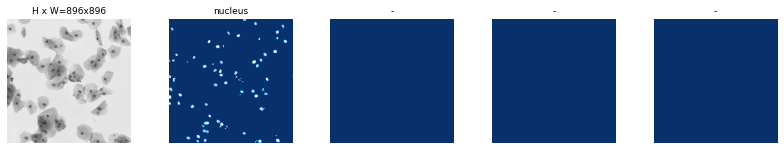

416 21 ['BG', 'nucleus']


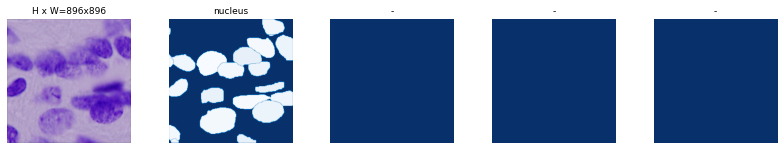

302 29 ['BG', 'nucleus']


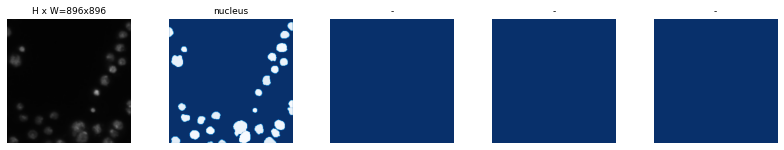

362 9 ['BG', 'nucleus']


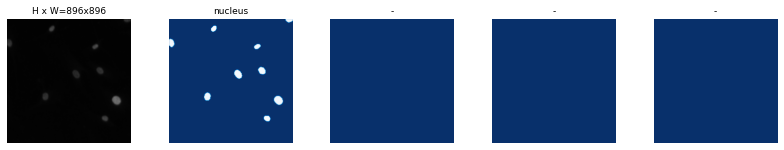

In [29]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(image_id, len(class_ids),dataset_train.class_names)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [32]:
# Choosing sepecif kind of weight, imagenet, coco, or last
init_with = "coco"  

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [23]:
    def train(self, train_dataset, val_dataset, learning_rate, epochs, layers,
              augmentation=None, custom_callbacks=None, no_augmentation_sources=None):
        assert self.mode == "training", "Create model in training mode."

        # Pre-defined layer regular expressions
        layer_regex = {
            # all layers but the backbone
            "heads": r"(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            # From a specific Resnet stage and up
            "3+": r"(res3.*)|(bn3.*)|(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            "4+": r"(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            "5+": r"(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            # All layers
            "all": ".*",
        }
        if layers in layer_regex.keys():
            layers = layer_regex[layers]

        # Data generators
        train_generator = data_generator(train_dataset, self.config, shuffle=True,
                                         augmentation=augmentation,
                                         batch_size=self.config.BATCH_SIZE,
                                         no_augmentation_sources=no_augmentation_sources)
        val_generator = data_generator(val_dataset, self.config, shuffle=True,
                                       batch_size=self.config.BATCH_SIZE)

        # Create log_dir if it does not exist
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)

        # Callbacks
        callbacks = [
            keras.callbacks.TensorBoard(log_dir=self.log_dir,
                                        histogram_freq=0, write_graph=True, write_images=False),
            keras.callbacks.ModelCheckpoint(self.checkpoint_path,
                                            verbose=0, save_weights_only=True),
        ]

        # Add custom callbacks to the list
        if custom_callbacks:
            callbacks += custom_callbacks

        # Train
        log("\nStarting at epoch {}. LR={}\n".format(self.epoch, learning_rate))
        log("Checkpoint Path: {}".format(self.checkpoint_path))
        self.set_trainable(layers)
        self.compile(learning_rate, self.config.LEARNING_MOMENTUM)

        if os.name is 'nt':
            workers = 0
        else:
            workers = multiprocessing.cpu_count()

        self.keras_model.fit_generator(
            train_generator,
            initial_epoch=self.epoch,
            epochs=epochs,
            steps_per_epoch=self.config.STEPS_PER_EPOCH,
            callbacks=callbacks,
            validation_data=val_generator,
            validation_steps=self.config.VALIDATION_STEPS,
            max_queue_size=100,
            workers=workers,
            use_multiprocessing=True,
        )
        self.epoch = max(self.epoch, epochs)

In [33]:
'''model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')'''
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=20, 
            layers="all")


Starting at epoch 0. LR=0.0001

Checkpoint Path: /content/logs/shapes20220123T1608/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b         

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/20
199/200 [============================>.] - ETA: 2s - loss: 2.6094 - rpn_class_loss: 0.3598 - rpn_bbox_loss: 0.9717 - mrcnn_class_loss: 0.1920 - mrcnn_bbox_loss: 0.5410 - mrcnn_mask_loss: 0.5450

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



200/200 [==============================] - 975s 5s/step - loss: 2.6029 - rpn_class_loss: 0.3583 - rpn_bbox_loss: 0.9703 - mrcnn_class_loss: 0.1917 - mrcnn_bbox_loss: 0.5391 - mrcnn_mask_loss: 0.5434 - val_loss: 1.5268 - val_rpn_class_loss: 0.1136 - val_rpn_bbox_loss: 0.7187 - val_mrcnn_class_loss: 0.1485 - val_mrcnn_bbox_loss: 0.2383 - val_mrcnn_mask_loss: 0.3077
Epoch 2/20
200/200 [==============================] - 529s 3s/step - loss: 1.3642 - rpn_class_loss: 0.1001 - rpn_bbox_loss: 0.6570 - mrcnn_class_loss: 0.1510 - mrcnn_bbox_loss: 0.2073 - mrcnn_mask_loss: 0.2487 - val_loss: 1.1788 - val_rpn_class_loss: 0.0610 - val_rpn_bbox_loss: 0.5366 - val_mrcnn_class_loss: 0.1622 - val_mrcnn_bbox_loss: 0.1897 - val_mrcnn_mask_loss: 0.2294
Epoch 3/20
200/200 [==============================] - 657s 3s/step - loss: 1.2110 - rpn_class_loss: 0.0945 - rpn_bbox_loss: 0.5400 - mrcnn_class_loss: 0.1699 - mrcnn_bbox_loss: 0.1864 - mrcnn_mask_loss: 0.2201 - val_loss: 1.1666 - val_rpn_class_loss: 0.084

## Save weights

In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard
%tensorboard --logdir logs

In [34]:
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes4.h5")
model.keras_model.save_weights(model_path)

In [ ]:
import plotly.graph_objects as go

# Add data
'''
month = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'
         '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
loss =
rpn_class_loss = 
rpn_bbox_loss = 
mrcnn_class_loss = 
mrcnn_bbox_loss = 
mrcnn_mask_loss = 
val_loss
val_rpn_class_loss
val_rpn_bbox_loss
val_mrcnn_class_loss
val_mrcnn_bbox_loss
val_mrcnn_mask_loss
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=month, y=high_2014, name='High 2014',
                         line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=month, y=low_2014, name = 'Low 2014',
                         line=dict(color='royalblue', width=4)))
fig.add_trace(go.Scatter(x=month, y=high_2007, name='High 2007',
                         line=dict(color='firebrick', width=4,
                              dash='dash') # dash options include 'dash', 'dot', and 'dashdot'
))
fig.add_trace(go.Scatter(x=month, y=low_2007, name='Low 2007',
                         line = dict(color='royalblue', width=4, dash='dash')))
fig.add_trace(go.Scatter(x=month, y=high_2000, name='High 2000',
                         line = dict(color='firebrick', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=month, y=low_2000, name='Low 2000',
                         line=dict(color='royalblue', width=4, dash='dot')))

# Edit the layout
fig.update_layout(title='Average High and Low Temperatures in New York',
                   xaxis_title='Month',
                   yaxis_title='Temperature (degrees F)')


fig.show()
'''

# Detection
Analyzing the correctness of Mask-RCNN algorithm.

In [24]:
    def detect(self, images, verbose=0):
        assert self.mode == "inference", "Create model in inference mode."
        assert len(
            images) == self.config.BATCH_SIZE, "len(images) must be equal to BATCH_SIZE"

        if verbose:
            log("Processing {} images".format(len(images)))
            for image in images:
                log("image", image)

        # Mold inputs to format expected by the neural network
        molded_images, image_metas, windows = self.mold_inputs(images)

        # Validate image sizes
        # All images in a batch MUST be of the same size
        image_shape = molded_images[0].shape
        for g in molded_images[1:]:
            assert g.shape == image_shape,\
                "After resizing, all images must have the same size. Check IMAGE_RESIZE_MODE and image sizes."

        # Anchors
        anchors = self.get_anchors(image_shape)
        # Duplicate across the batch dimension because Keras requires it
        # TODO: can this be optimized to avoid duplicating the anchors?
        anchors = np.broadcast_to(anchors, (self.config.BATCH_SIZE,) + anchors.shape)

        if verbose:
            log("molded_images", molded_images)
            log("image_metas", image_metas)
            log("anchors", anchors)
        # Run object detection
        detections, _, _, mrcnn_mask, _, _, _ =\
            self.keras_model.predict([molded_images, image_metas, anchors], verbose=0)
        # Process detections
        results = []
        for i, image in enumerate(images):
            final_rois, final_class_ids, final_scores, final_masks =\
                self.unmold_detections(detections[i], mrcnn_mask[i],
                                       image.shape, molded_images[i].shape,
                                       windows[i])
            results.append({
                "rois": final_rois,
                "class_ids": final_class_ids,
                "scores": final_scores,
                "masks": final_masks,
            })
        return results

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes4.h5")
#model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

original_image           shape: (896, 896, 3)         min:    1.00000  max:   94.87755  float64
image_meta               shape: (14,)                 min:    0.00000  max:  896.00000  int64
gt_class_id              shape: (8,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (8, 4)                min:   54.00000  max:  896.00000  int32
gt_mask                  shape: (896, 896, 8)         min:    0.00000  max:  255.00000  uint8


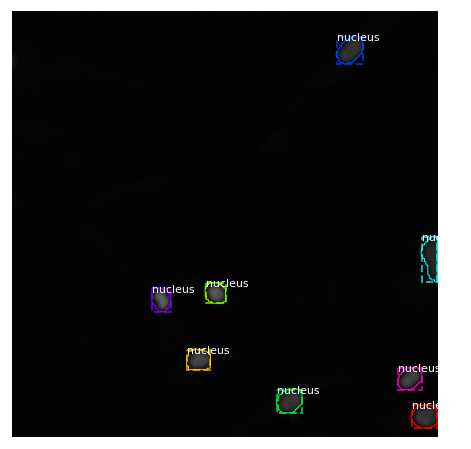

In [40]:
# Test on a random image
image_id = 2 #random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (896, 896, 3)         min:    1.00000  max:   94.87755  float64
molded_images            shape: (1, 896, 896, 3)      min: -122.70000  max:   -9.02245  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  896.00000  int64
anchors                  shape: (1, 200508, 4)        min:   -0.20226  max:    1.13075  float32


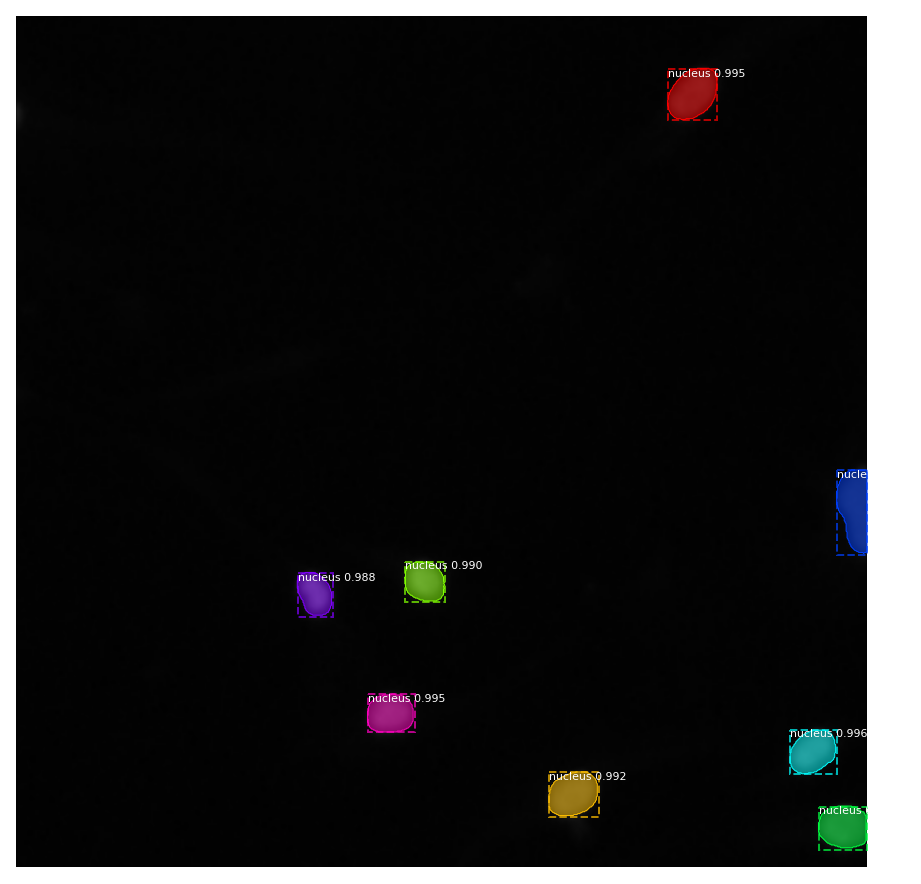

In [41]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

# Evaluation
Testing our test-set so as to evaluate algorithm's truthness.

In [42]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 30 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 30)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.8526419680727606


In [ ]:

X_test = np.zeros((len(test_ids), config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], 3), dtype=np.uint8)
sizes_test = []
_test_ids = []

print('Getting and resizing test images ... ')
#sys.stdout.flush()
for n, id_ in enumerate(test_ids):
    _test_ids.append([id_])
    path = TEST_PATH + '1'
    img = imread(path + '/images/' + 'F1_1' + '.png')[:,:,:3]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
    X_test[n] = img

In [ ]:
print("checking a test image with masks ...")
results = model.detect([X_test[1]], verbose=1)

r = results[0]
visualize.display_instances(X_test[1], r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])